<a href="https://colab.research.google.com/github/HadarMiriamIsaacson/BS-SE-24-207/blob/main/Demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

test1 23.08.24

In [ ]:
file_path='/content/drive/MyDrive/פרויקט גמר ניסן והדר/new/data_final.xlsx'

In [ ]:
pip install datasets

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import Dataset, DatasetDict
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords

In [ ]:
# Download stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # Get English stopwords

# Set the random seed for reproducibility
torch.manual_seed(0)

# Define model checkpoint and tokenizer with add_prefix_space=True
model_checkpoint = "distilroberta-base"  # Replace with your desired model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)  # Important for pre-tokenized inputs

# Load dataset from the Excel file
data = pd.read_excel(file_path)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Prepare data by grouping words and labels for each job description
def prepare_data(data):
    examples = {"tokens": [], "labels": []}
    grouped = data.groupby('job_description')
    for job_desc, group in grouped:
        words = group['word'].tolist()
        labels = group['final'].tolist()
        examples["tokens"].append(words)
        examples["labels"].append(labels)
    return examples

# Use the prepare_data function to get tokens and labels
examples = prepare_data(data)

# Split the data into training and validation sets
train_examples, val_examples = train_test_split(
    list(zip(examples["tokens"], examples["labels"])), test_size=0.2, random_state=42
)

# Convert back to the dictionary format expected by the tokenizer
train_data = {"tokens": [x[0] for x in train_examples], "labels": [x[1] for x in train_examples]}
val_data = {"tokens": [x[0] for x in val_examples], "labels": [x[1] for x in val_examples]}

In [ ]:
# Data Preparation: Tokenization and Label Alignment
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore special tokens like padding
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # Use the label of the first word piece
            else:
                label_ids.append(-100)  # Ignore subsequent pieces of split words
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict(tokenize_and_align_labels(train_data))
val_dataset = Dataset.from_dict(tokenize_and_align_labels(val_data))

# Load the model for token classification
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=2)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [ ]:
# Compute metrics function for model evaluation
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    # Remove ignored index (special tokens) and flatten the output
    true_predictions = [
        p for prediction, label in zip(predictions, labels)
        for (p, l) in zip(prediction, label) if l != -100
    ]
    true_labels = [
        l for prediction, label in zip(predictions, labels)
        for (p, l) in zip(prediction, label) if l != -100
    ]

    # Calculate metrics
    accuracy = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    f1_macro = f1_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    f1_class_1 = f1_score(y_true=true_labels, y_pred=true_predictions, labels=[1], average="macro")
    f1_class_0 = f1_score(y_true=true_labels, y_pred=true_predictions, labels=[0], average="macro")

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_class_1': f1_class_1,
        'f1_class_0': f1_class_0
    }

In [ ]:
# Define training arguments
batch_size = 16  # Adjust as needed
args = TrainingArguments(
    output_dir=f"{model_checkpoint}-finetuned-keyword",
    eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=8e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=6,
    lr_scheduler_type="linear",
    seed=0,
    load_best_model_at_end=True
)

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=val_dataset,  # Validation dataset
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# Start training
trainer.train()

# Save the best model
trainer.save_model("best_model")

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Class 1,F1 Class 0
1,0.621500,0.484459,0.750542,0.447833,0.038997,0.856668
2,0.428400,0.341856,0.823572,0.682430,0.470716,0.894143
3,0.264400,0.206873,0.962401,0.948789,0.922388,0.975191
4,0.166200,0.125802,0.978670,0.972038,0.958421,0.985655
5,0.108500,0.086277,0.980477,0.974467,0.962079,0.986855
6,0.084800,0.074725,0.981200,0.975367,0.963380,0.987354


In [ ]:

# Keyword Cleaning Function
def clean_keyword(keyword):
    allowed_punctuation = {'#', '.', '+'}
    cleaned = ''.join([char for char in keyword if char.isalnum() or char in allowed_punctuation or char.isspace()])
    cleaned_words = [word for word in cleaned.split() if word.lower() not in stop_words]
    cleaned_keyword = ' '.join(cleaned_words)
    return cleaned_keyword

# Keyword Extraction Function
def extract_keywords_model(data, batch_size=2):
    keywords = []
    for idx in range(0, len(data), batch_size):
        inputs = tokenizer(data[idx: idx + batch_size], return_tensors='pt', padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=-1).argmax(-1)

        for idx_item in range(predictions.shape[0]):
            indices_single = []
            keywords_item = []
            for idx, label in enumerate(predictions[idx_item].tolist()):
                if label == 1:
                    indices_single.append(idx)
                elif label == 0 and len(indices_single) > 0:
                    decoded_keyword = tokenizer.decode(inputs.input_ids[idx_item][indices_single], skip_special_tokens=True).strip()
                    cleaned_keyword = clean_keyword(decoded_keyword)
                    if cleaned_keyword and not any(tok in cleaned_keyword for tok in ["<pad>", "</s>", "<s>", "[SEP]"]):
                        keywords_item.append(cleaned_keyword)
                    indices_single = []
            if len(indices_single) > 0:
                decoded_keyword = tokenizer.decode(inputs.input_ids[idx_item][indices_single], skip_special_tokens=True).strip()
                cleaned_keyword = clean_keyword(decoded_keyword)
                if cleaned_keyword and not any(tok in cleaned_keyword for tok in ["<pad>", "</s>", "<s>", "[SEP]"]):
                    keywords_item.append(cleaned_keyword)
            keywords.append(keywords_item)
    return keywords

In [ ]:

# Test the keyword extraction function with new data
new_data = [
    "The software developer must have experience in C++, .NET, and WPF.",
    "We are looking for a data scientist with skills in SQL, Python, machine learning, and data analysis.",
    "We are hiring a Senior Full Stack Developer. Proficient with: Node, React, Web Development, AWS infrastructure"
]

# Extract keywords
model_keywords = extract_keywords_model(new_data)

model_keywords = [list(set(keywords)) for keywords in model_keywords]  # Remove duplicates
model_keywords = [sorted(keywords) for keywords in model_keywords]  # Sort alphabetically
formatted_keywords = [', '.join(keywords) for keywords in model_keywords]  # Format as a string

# Display the results
for i, keywords_str in enumerate(formatted_keywords):
    print(f"Formatted Keywords in text {i+1}: {keywords_str}")

Formatted Keywords in text 1: experience C++.NET WPF., software developer must
Formatted Keywords in text 2: looking data scientist skills SQL Python machine learning data analysis.
Formatted Keywords in text 3: hiring Senior Full Stack Developer. Proficient Node React Web Development AWS infrastructure


save model test1

In [ ]:
#locally:
# Save the model and tokenizer locally
save_directory = "./fine-tuned-keyword-extraction-230824-test1"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('./fine-tuned-keyword-extraction-230824-test1/tokenizer_config.json',
 './fine-tuned-keyword-extraction-230824-test1/special_tokens_map.json',
 './fine-tuned-keyword-extraction-230824-test1/vocab.json',
 './fine-tuned-keyword-extraction-230824-test1/merges.txt',
 './fine-tuned-keyword-extraction-230824-test1/added_tokens.json',
 './fine-tuned-keyword-extraction-230824-test1/tokenizer.json')

In [ ]:
# Load the saved model and tokenizer to verify they were saved correctly
loaded_model = AutoModelForTokenClassification.from_pretrained(save_directory)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)


In [ ]:
# Save the state of the trainer (including optimizer, scheduler, etc.)
trainer.save_state()


In [ ]:
# Save the model and tokenizer to Google Drive
drive_save_directory = '/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test1'
model.save_pretrained(drive_save_directory)
tokenizer.save_pretrained(drive_save_directory)


test2 23.08.24

In [ ]:
file_path='/content/drive/MyDrive/פרויקט גמר ניסן והדר/new/data_final.xlsx'

In [ ]:
pip install datasets

In [ ]:
import torch
import numpy as np
from transformers import AutoModelForTokenClassification, AutoTokenizer, TrainingArguments, Trainer, DataCollatorForTokenClassification
from datasets import Dataset
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split  # Add this import
import pandas as pd
import nltk
from nltk.corpus import stopwords

In [ ]:
# Download stopwords from nltk
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))  # Get English stopwords

# Set the random seed for reproducibility
torch.manual_seed(0)

# Define model checkpoint and tokenizer with add_prefix_space=True
model_checkpoint = "distilroberta-base"  # Replace with your desired model checkpoint
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, add_prefix_space=True)  # Important for pre-tokenized inputs

# Load dataset from the Excel file
data = pd.read_excel(file_path)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Prepare data by grouping words and labels for each job description
def prepare_data(data):
    examples = {"tokens": [], "labels": []}
    grouped = data.groupby('job_description')
    for job_desc, group in grouped:
        words = group['word'].tolist()
        labels = group['final'].tolist()
        examples["tokens"].append(words)
        examples["labels"].append(labels)
    return examples

# Use the prepare_data function to get tokens and labels
examples = prepare_data(data)

# Split the data into training and validation sets
train_examples, val_examples = train_test_split(
    list(zip(examples["tokens"], examples["labels"])), test_size=0.2, random_state=42
)

# Convert back to the dictionary format expected by the tokenizer
train_data = {"tokens": [x[0] for x in train_examples], "labels": [x[1] for x in train_examples]}
val_data = {"tokens": [x[0] for x in val_examples], "labels": [x[1] for x in val_examples]}

In [ ]:
# Data Preparation: Tokenization and Label Alignment
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(examples["tokens"], truncation=True, is_split_into_words=True)
    labels = []
    for i, label in enumerate(examples["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Ignore special tokens like padding
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # Use the label of the first word piece
            else:
                label_ids.append(-100)  # Ignore subsequent pieces of split words
            previous_word_idx = word_idx
        labels.append(label_ids)
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [ ]:
# Convert to Hugging Face Dataset format
train_dataset = Dataset.from_dict(tokenize_and_align_labels(train_data))
val_dataset = Dataset.from_dict(tokenize_and_align_labels(val_data))

# Load the model for token classification
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=2)

# Move the model to the GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-5): 6 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (Lay

In [ ]:
# Compute metrics function for model evaluation
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=-1)

    # Remove ignored index (special tokens) and flatten the output
    true_predictions = [
        p for prediction, label in zip(predictions, labels)
        for (p, l) in zip(prediction, label) if l != -100
    ]
    true_labels = [
        l for prediction, label in zip(predictions, labels)
        for (p, l) in zip(prediction, label) if l != -100
    ]

    # Calculate metrics
    accuracy = accuracy_score(y_true=true_labels, y_pred=true_predictions)
    f1_macro = f1_score(y_true=true_labels, y_pred=true_predictions, average="macro")
    f1_class_1 = f1_score(y_true=true_labels, y_pred=true_predictions, labels=[1], average="macro")
    f1_class_0 = f1_score(y_true=true_labels, y_pred=true_predictions, labels=[0], average="macro")

    return {
        'accuracy': accuracy,
        'f1_macro': f1_macro,
        'f1_class_1': f1_class_1,
        'f1_class_0': f1_class_0
    }

In [ ]:
# Define training arguments
batch_size = 16  # Adjust as needed
args = TrainingArguments(
    output_dir=f"{model_checkpoint}-finetuned-keyword",
    eval_strategy="epoch",  # Changed from evaluation_strategy to eval_strategy
    save_strategy="epoch",
    logging_strategy="epoch",
    learning_rate=8e-6,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=6,
    lr_scheduler_type="linear",
    seed=0,
    load_best_model_at_end=True
)

# Data collator for token classification
data_collator = DataCollatorForTokenClassification(tokenizer)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_dataset,  # Training dataset
    eval_dataset=val_dataset,  # Validation dataset
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
# Start training
trainer.train()

# Save the best model
trainer.save_model("best_model")

Epoch,Training Loss,Validation Loss,Accuracy,F1 Macro,F1 Class 1,F1 Class 0
1,0.621500,0.484459,0.750542,0.447833,0.038997,0.856668
2,0.428400,0.341856,0.823572,0.682430,0.470716,0.894143
3,0.264400,0.206873,0.962401,0.948789,0.922388,0.975191
4,0.166200,0.125802,0.978670,0.972038,0.958421,0.985655
5,0.108500,0.086277,0.980477,0.974467,0.962079,0.986855
6,0.084800,0.074725,0.981200,0.975367,0.963380,0.987354


In [ ]:
# Evaluate the model on the validation set
evaluation_results = trainer.evaluate()
print("Evaluation Results:")
for key, value in evaluation_results.items():
    print(f"{key}: {value:.4f}")

Evaluation Results:
eval_loss: 0.0747
eval_accuracy: 0.9812
eval_f1_macro: 0.9754
eval_f1_class_1: 0.9634
eval_f1_class_0: 0.9874
eval_runtime: 0.5687
eval_samples_per_second: 80.8790
eval_steps_per_second: 5.2750
epoch: 6.0000


In [ ]:
# Keyword Cleaning Function
def clean_keyword(keyword):
    allowed_punctuation = {'#', '.', '+'}
    cleaned = ''.join([char for char in keyword if char.isalnum() or char in allowed_punctuation or char.isspace()])
    cleaned_words = [word for word in cleaned.split() if word.lower() not in stop_words]
    cleaned_keyword = ' '.join(cleaned_words)
    return cleaned_keyword

# Keyword Extraction Function
def extract_keywords_model(data, batch_size=2):
    keywords = []
    for idx in range(0, len(data), batch_size):
        inputs = tokenizer(data[idx: idx + batch_size], return_tensors='pt', padding=True, truncation=True).to(device)
        outputs = model(**inputs)
        predictions = torch.softmax(outputs.logits, dim=-1).argmax(-1)

        for idx_item in range(predictions.shape[0]):
            indices_single = []
            keywords_item = []
            for idx, label in enumerate(predictions[idx_item].tolist()):
                if label == 1:
                    indices_single.append(idx)
                elif label == 0 and len(indices_single) > 0:
                    decoded_keyword = tokenizer.decode(inputs.input_ids[idx_item][indices_single], skip_special_tokens=True).strip()
                    cleaned_keyword = clean_keyword(decoded_keyword)
                    if cleaned_keyword and not any(tok in cleaned_keyword for tok in ["<pad>", "</s>", "<s>", "[SEP]"]):
                        keywords_item.append(cleaned_keyword)
                    indices_single = []
            if len(indices_single) > 0:
                decoded_keyword = tokenizer.decode(inputs.input_ids[idx_item][indices_single], skip_special_tokens=True).strip()
                cleaned_keyword = clean_keyword(decoded_keyword)
                if cleaned_keyword and not any(tok in cleaned_keyword for tok in ["<pad>", "</s>", "<s>", "[SEP]"]):
                    keywords_item.append(cleaned_keyword)
            keywords.append(keywords_item)
    return keywords

In [ ]:
# Test the keyword extraction function with new data
new_data = [
    "The software developer must have experience in C++, .NET, and WPF.",
    "We are looking for a data scientist with skills in SQL, Python, machine learning, and data analysis.",
    "We are hiring a Senior Full Stack Developer. Proficient with: Node, React, Web Development, AWS infrastructure"
]

# Extract keywords
model_keywords = extract_keywords_model(new_data)

# Post-process and Display the Results
formatted_keywords = [', '.join(keywords) for keywords in model_keywords]

# Display the results
for i, keywords_str in enumerate(formatted_keywords):
    print(f"Formatted Keywords in text {i+1}: {keywords_str}")

Formatted Keywords in text 1: software developer must, experience C++.NET WPF.
Formatted Keywords in text 2: looking data scientist skills SQL Python machine learning data analysis.
Formatted Keywords in text 3: hiring Senior Full Stack Developer. Proficient Node React Web Development AWS infrastructure


save model test2

In [ ]:
#locally:
# Save the model and tokenizer locally
save_directory = "./fine-tuned-keyword-extraction-230824-test2"
model.save_pretrained(save_directory)
tokenizer.save_pretrained(save_directory)


('./fine-tuned-keyword-extraction-230824-test2/tokenizer_config.json',
 './fine-tuned-keyword-extraction-230824-test2/special_tokens_map.json',
 './fine-tuned-keyword-extraction-230824-test2/vocab.json',
 './fine-tuned-keyword-extraction-230824-test2/merges.txt',
 './fine-tuned-keyword-extraction-230824-test2/added_tokens.json',
 './fine-tuned-keyword-extraction-230824-test2/tokenizer.json')

In [ ]:
# Load the saved model and tokenizer to verify they were saved correctly
loaded_model = AutoModelForTokenClassification.from_pretrained(save_directory)
loaded_tokenizer = AutoTokenizer.from_pretrained(save_directory)


In [ ]:
# Save the state of the trainer (including optimizer, scheduler, etc.)
trainer.save_state()


In [ ]:
# Save the model and tokenizer to Google Drive
drive_save_directory = '/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test2'
model.save_pretrained(drive_save_directory)
tokenizer.save_pretrained(drive_save_directory)


('/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test2/tokenizer_config.json',
 '/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test2/special_tokens_map.json',
 '/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test2/vocab.json',
 '/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test2/merges.txt',
 '/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test2/added_tokens.json',
 '/content/drive/MyDrive/fine-tuned-keyword-extraction-230824-test2/tokenizer.json')

visualization of results:

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score

# Load the Excel file
file_path = '/content/drive/MyDrive/פרויקט גמר ניסן והדר/new/data_final.xlsx'
data = pd.read_excel(file_path)
print(len(data))

13693


In [ ]:
# Extract the relevant columns
final_labels = data['final']
chatgpt_predictions = data['chatgpt']
keybert_predictions = data['KeyBert']

In [ ]:
from sklearn.metrics import cohen_kappa_score
filtered_df = data[(data['hadar'] != '-') & (data['nisan'] != '-')]

# Extract the 'hadar' and 'nisan' columns as lists
x = filtered_df['hadar'].tolist()
y = filtered_df['nisan'].tolist()

# Calculate Cohen's kappa score
kappa_score = cohen_kappa_score(x, y)
kappa_score

0.9520964471897954

In [ ]:
# Calculate accuracy, F1 score, and F1 macro score for ChatGPT predictions
chatgpt_accuracy = accuracy_score(final_labels, chatgpt_predictions)
#chatgpt_f1 = f1_score(final_labels, chatgpt_predictions)
chatgpt_f1_macro = f1_score(final_labels, chatgpt_predictions, average='macro')

# Calculate accuracy, F1 score, and F1 macro score for KeyBert predictions
keybert_accuracy = accuracy_score(final_labels, keybert_predictions)
#keybert_f1 = f1_score(final_labels, keybert_predictions)
keybert_f1_macro = f1_score(final_labels, keybert_predictions, average='macro')

# Output the results
print("ChatGPT Predictions:")
print(f"Accuracy: {chatgpt_accuracy}")
#print(f"F1 Score: {chatgpt_f1}")
print(f"F1 Macro Score: {chatgpt_f1_macro}")

print("\nKeyBert Predictions:")
print(f"Accuracy: {keybert_accuracy}")
#print(f"F1 Score: {keybert_f1}")
print(f"F1 Macro Score: {keybert_f1_macro}")


ChatGPT Predictions:
Accuracy: 0.7816402541444534
F1 Macro Score: 0.5997329589301807

KeyBert Predictions:
Accuracy: 0.7316877236544219
F1 Macro Score: 0.4346938011401934


In [ ]:
from sklearn.metrics import confusion_matrix, balanced_accuracy_score

# Confusion Matrix for ChatGPT predictions
chatgpt_confusion_matrix = confusion_matrix(final_labels, chatgpt_predictions)

# Balanced Accuracy for ChatGPT predictions
chatgpt_balanced_accuracy = balanced_accuracy_score(final_labels, chatgpt_predictions)

# Repeat the same for KeyBert predictions
keybert_confusion_matrix = confusion_matrix(final_labels, keybert_predictions)
keybert_balanced_accuracy = balanced_accuracy_score(final_labels, keybert_predictions)

# Output the results
print("ChatGPT Predictions:")
print(f"Confusion Matrix:\n{chatgpt_confusion_matrix}")
print(f"Balanced Accuracy: {chatgpt_balanced_accuracy}")

print("\nKeyBert Predictions:")
print(f"Confusion Matrix:\n{keybert_confusion_matrix}")
print(f"Balanced Accuracy: {keybert_balanced_accuracy}")


ChatGPT Predictions:
Confusion Matrix:
[[9967    5]
 [2985  736]]
Balanced Accuracy: 0.5986474436942655

KeyBert Predictions:
Confusion Matrix:
[[9972    0]
 [3674   47]]
Balanced Accuracy: 0.5063155065842515


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

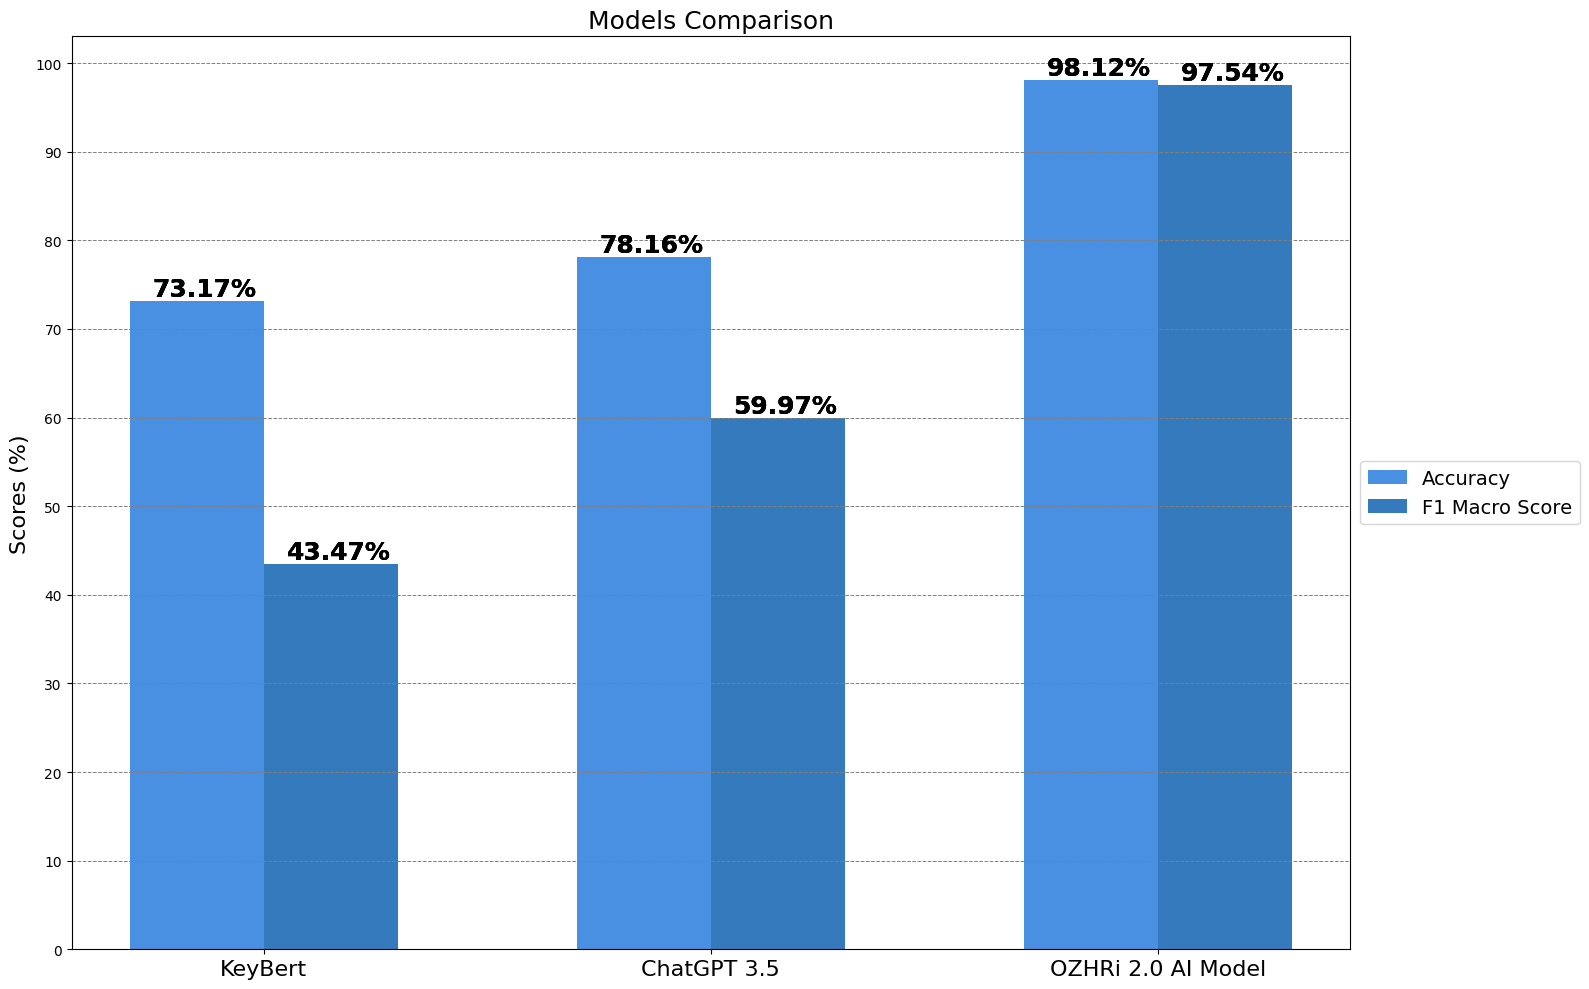

In [ ]:
# Data for the models
models = ['KeyBert', 'ChatGPT 3.5', 'OZHRi 2.0 AI Model']
accuracy_scores = [0.7316877236544219, 0.7816402541444534, 0.9812]
f1_macro_scores = [0.4346938011401934, 0.5997329589301807, 0.9754]

# Convert scores to percentages
accuracy_scores = [score * 100 for score in accuracy_scores]
f1_macro_scores = [score * 100 for score in f1_macro_scores]

# Create a bar chart to compare Accuracy and F1 Macro Score
x = np.arange(len(models))  # the label locations
width = 0.3  # the width of the bars

fig, ax = plt.subplots(figsize=(16, 10))

# Use a blue color palette
rects1 = ax.bar(x - width/2, accuracy_scores, width, label='Accuracy', color='#4A90E2')
rects2 = ax.bar(x + width/2, f1_macro_scores, width, label='F1 Macro Score', color='#357ABD')

# Add some text for labels, title, and custom x-axis tick labels, etc.
#ax.set_xlabel('Models', fontsize=16)
ax.set_ylabel('Scores (%)', fontsize=16)
ax.set_title('Models Comparison', fontsize=18)
ax.set_xticks(x)
ax.set_xticklabels(models, fontsize=16)

# Set Y axis ticks and add grid
ax.set_yticks(np.arange(0, 110, 10))
ax.grid(True, axis='y', linestyle='--', linewidth=0.7, color='gray')

# Place the legend outside the plot
ax.legend(fontsize=14, loc='center left', bbox_to_anchor=(1, 0.5))

# Attach a text label above each bar, displaying its height with increased font size and bold for OZHRi model
def autolabel(rects, model_name):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width()/1.8, height),
                    xytext=(0, 0),  # 5 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=18, fontweight='bold')

autolabel(rects1, models[0])
autolabel(rects2, models[0])
autolabel(rects1, models[1])
autolabel(rects2, models[1])
autolabel(rects1, models[2])
autolabel(rects2, models[2])

fig.tight_layout()

plt.show()


Overfitting test:

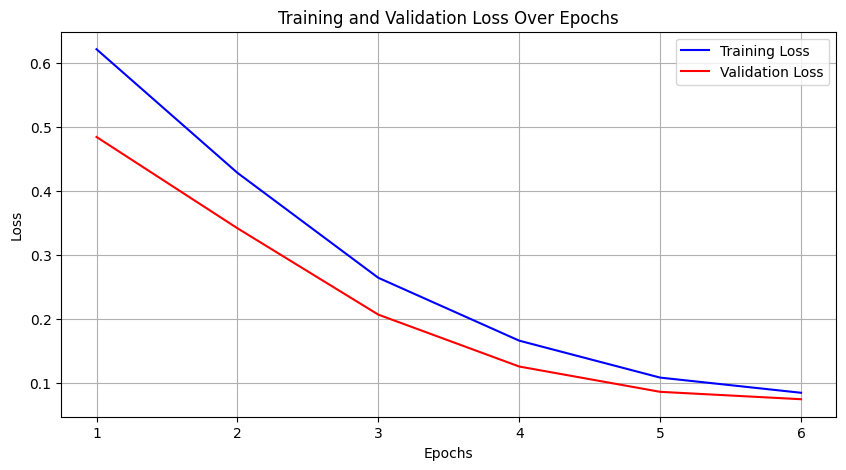

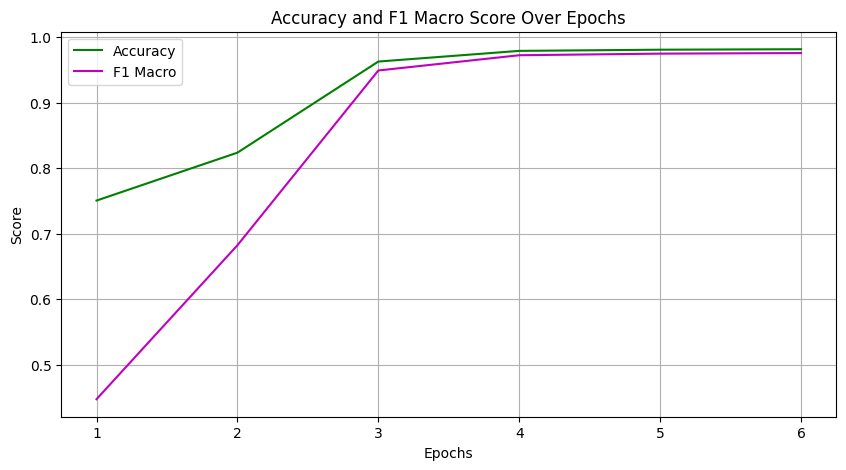

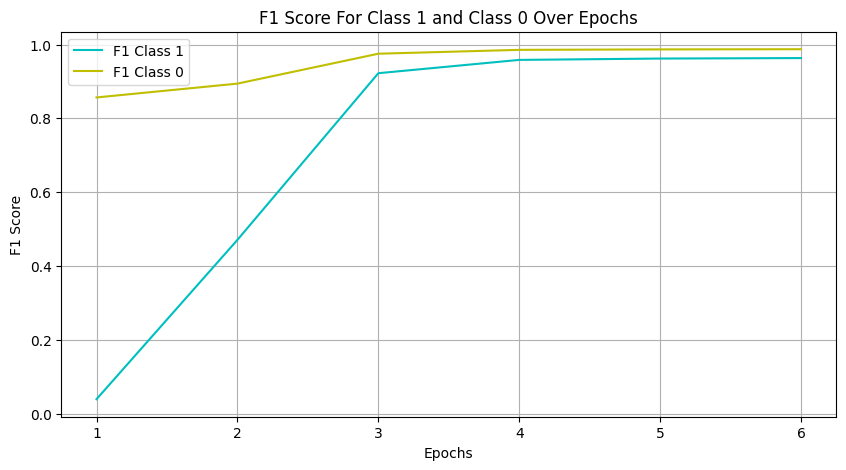

In [ ]:
import matplotlib.pyplot as plt

# Data from the provided training and validation results
epochs = [1, 2, 3, 4, 5, 6]
training_loss = [0.621500, 0.428400, 0.264400, 0.166200, 0.108500, 0.084800]
validation_loss = [0.484459, 0.341856, 0.206873, 0.125802, 0.086277, 0.074725]
accuracy = [0.750542, 0.823572, 0.962401, 0.978670, 0.980477, 0.981200]
f1_macro = [0.447833, 0.682430, 0.948789, 0.972038, 0.974467, 0.975367]
f1_class_1 = [0.038997, 0.470716, 0.922388, 0.958421, 0.962079, 0.963380]
f1_class_0 = [0.856668, 0.894143, 0.975191, 0.985655, 0.986855, 0.987354]

# 1. Plotting the Training and Validation Loss Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, training_loss, 'b-', label='Training Loss')
plt.plot(epochs, validation_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 2. Plotting the Accuracy and F1 Macro Score Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, accuracy, 'g-', label='Accuracy')
plt.plot(epochs, f1_macro, 'm-', label='F1 Macro')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.title('Accuracy and F1 Macro Score Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

# 3. Plotting the F1 Score for Class 1 and Class 0 Over Epochs
plt.figure(figsize=(10, 5))
plt.plot(epochs, f1_class_1, 'c-', label='F1 Class 1')
plt.plot(epochs, f1_class_0, 'y-', label='F1 Class 0')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Score For Class 1 and Class 0 Over Epochs')
plt.legend()
plt.grid(True)
plt.show()


Results Analysis
Training and Validation Loss

Both the training and validation losses were recorded over the course of six epochs, and the results show a consistent decrease in both metrics:

Training Loss: The training loss decreased steadily from an initial value of 0.6215 to a final value of 0.0848. This consistent reduction indicates that the model was effectively learning the patterns within the training data, minimizing the error.

Validation Loss: Similarly, the validation loss decreased from an initial value of 0.4845 to a final value of 0.0747. The decline in validation loss, which closely parallels the training loss, suggests that the model was not only learning effectively but also generalizing well to the validation data. The proximity of the final validation loss to the training loss is indicative of good generalization and suggests that overfitting is being controlled effectively.

Interpretation: The steady decrease in both training and validation loss across epochs is a positive sign, demonstrating that the model improves its performance with more exposure to the data. The close alignment between the final training and validation loss values indicates that the model is not overfitting to the training data. This balance shows that the model has learned general patterns that apply well to unseen data.

Accuracy and F1 Macro Score
Throughout the training process, both the accuracy and F1 Macro scores were monitored, reflecting the model's ability to correctly classify both the majority and minority classes:

Accuracy: The accuracy of the model improved from an initial value of 0.7505 to a final value of 0.9812. This significant increase indicates that the model became increasingly proficient at correctly classifying instances in both the training and validation datasets.

F1 Macro Score: The F1 Macro score, which provides a balanced measure of precision and recall for both classes, showed a marked improvement from 0.4478 to 0.9754. This increase is significant because it demonstrates that the model is effectively managing the trade-off between precision and recall, ensuring that both types of classification errors (false positives and false negatives) are minimized.

Interpretation: The consistent increase in accuracy and F1 Macro scores suggests that the model's predictive power is robust across different epochs. The F1 Macro score's growth, in particular, highlights the model's balanced performance across classes, which is critical in scenarios with class imbalance.

F1 Scores for Class 1 and Class 0
Given the class imbalance (with class 1 being the minority class), it is crucial to analyze the F1 scores for each class separately to ensure that the model does not disproportionately favor the majority class:

F1 Score for Class 1 (Minority Class): The F1 score for class 1 started at a low value of 0.0390 but increased significantly to 0.9634 by the final epoch. This dramatic improvement indicates that the model initially struggled with correctly identifying instances of the minority class but became highly proficient over time. This increase shows that the model learned to recognize features relevant to the minority class effectively, despite its underrepresentation.

F1 Score for Class 0 (Majority Class): The F1 score for class 0 remained consistently high, starting at 0.8567 and reaching 0.9874 by the final epoch. This consistency suggests that the model was consistently able to classify the majority class correctly, maintaining high precision and recall.

Interpretation: The improvement in the F1 score for class 1 demonstrates the model's ability to adapt to class imbalances, learning to treat minority class instances with the same importance as those of the majority class. This balanced performance is crucial for applications where both classes are of importance, and errors in minority class predictions could be costly or critical.

Conclusion
The results from the training and validation phases indicate that the model is learning effectively and generalizing well to new data. The decreasing loss values and increasing accuracy and F1 scores across epochs suggest that overfitting is not a significant issue. The close alignment of the final training and validation losses further supports this conclusion, indicating that the model has not simply memorized the training data but has learned generalizable patterns.

The substantial improvement in the F1 score for class 1, from a very low initial value to a high final value, is particularly noteworthy. This improvement demonstrates the model's capacity to handle class imbalances effectively, making it well-suited for real-world applications where such imbalances are common. The model's ability to achieve high performance on both majority and minority classes ensures that it can be deployed in environments where equitable performance across different classes is crucial.

These findings suggest that the model is robust, scalable, and capable of maintaining high performance across varied data distributions. The balanced handling of class imbalance further indicates the model's readiness for application in domains where class imbalance is prevalent, and accurate predictions across all classes are essential.